# ADS 509 Sentiment Assignment
## Ghassan Seba

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
import matplotlib.pyplot as plt
import seaborn as sns

## Functions to handle text cleaning, tokenizing, etc. 

In [3]:
# Define punctuation variations
punctuation = set(punctuation)  # Optimize for comparison
tw_punct = punctuation - {"#"}

# Define regex patterns for whitespace and hashtags
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# Set of emojis across languages
all_language_emojis = set()

for country in emoji.EMOJI_DATA: 
    for em in emoji.EMOJI_DATA[country]: 
        all_language_emojis.add(em)

# Function to calculate descriptive statistics
def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Calculate and optionally print basic statistics about tokens.
    Returns a list of calculated values.
    """
    num_tokens = len(tokens)  
    num_unique_tokens = len(set(tokens))  
    lexical_diversity = num_unique_tokens / num_tokens if num_tokens > 0 else 0
    num_characters = sum(map(len, tokens))
    
    if verbose:
        print(f"\nThere are {num_tokens} tokens.")
        print(f"{num_unique_tokens} unique tokens.")
        print(f"{num_characters} characters.")
        print(f"Lexical diversity: {lexical_diversity:.3f}\n")
    
    return [num_tokens, num_unique_tokens, lexical_diversity, num_characters]

# Function to analyze statistics for multiple metrics
def analyze_statistics(stats_column, group_by_column, df, stats=['min', 'max', 'mean', 'median']):
    """
    Analyze and display aggregated statistics for different token metrics.
    Returns a dictionary of aggregated statistics.
    """
    stats_df = pd.DataFrame(stats_column.tolist(), columns=['num_tokens', 'num_unique_tokens', 'lexical_diversity', 'num_characters'])
    stats_df[group_by_column] = df[group_by_column].values

    lexical_diversity_stats = stats_df.groupby(group_by_column)['lexical_diversity'].agg(stats)
    num_tokens_stats = stats_df.groupby(group_by_column)['num_tokens'].agg(stats)
    unique_tokens_stats = stats_df.groupby(group_by_column)['num_unique_tokens'].agg(stats)
    characters_stats = stats_df.groupby(group_by_column)['num_characters'].agg(stats)

    print(f'Statistics for Lexical Diversity by {group_by_column}:')
    print(lexical_diversity_stats.round(4))
    print(f'\nStatistics for Number of Tokens by {group_by_column}:')
    print(num_tokens_stats.round(4))
    print(f'\nStatistics for Unique Tokens by {group_by_column}:')
    print(unique_tokens_stats.round(4))
    print(f'\nStatistics for Characters by {group_by_column}:')
    print(characters_stats.round(4))

    return {
        'lexical_diversity_stats': lexical_diversity_stats,
        'num_tokens_stats': num_tokens_stats,
        'unique_tokens_stats': unique_tokens_stats,
        'characters_stats': characters_stats
    }

# Check if a string contains any emoji
def contains_emoji(s):
    emojis = [ch for ch in str(s) if emoji.is_emoji(ch)]
    return len(emojis) > 0

# Remove stopwords from tokens
def remove_stop(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

# Remove punctuation from text
def remove_punctuation(text, punct_set=tw_punct):
    return "".join([ch for ch in text if ch not in punct_set])

# Tokenize text by splitting on whitespace
def tokenize(text):
    return re.compile(r'\s+').split(text)

# Apply a series of transformations to text
def prepare(text, pipeline):
    tokens = str(text)
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

# Read lyrics from files in a folder
def read_lyrics(folder):
    artist = os.path.basename(folder)
    lyrics_data = []
    for filename in os.listdir(folder):
        with open(os.path.join(folder, filename), 'r', encoding='utf-8') as file:
            lyrics_entry = file.read()
            lyrics_data.append({"artist": artist, "lyrics_entry": lyrics_entry})
    return lyrics_data

# Parse lyrics entry into artist, song title, and lyrics
def parse_lyrics(lyrics_entry, artist):
    song_title, song_lyrics = lyrics_entry.split('\n\n\n\n', 1)
    return {"artist": artist, "song_title": song_title, "song_lyrics": song_lyrics}

# Read Twitter followers data and add artist column
def read_followers_data(file_path, artist_name):
    df = pd.read_csv(file_path, delimiter='\t', quotechar='"', engine='python', on_bad_lines='skip')
    df['artist'] = artist_name
    return df[['artist'] + [col for col in df.columns if col != 'artist']]


In [4]:
# change `data_location` to the location of the folder on your machine.
data_location = "./"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [5]:
# Read in the lyrics data
cher_lyrics = read_lyrics(os.path.join(lyrics_folder, "cher"))
robyn_lyrics = read_lyrics(os.path.join(lyrics_folder, "robyn"))

# Combine both lists of
all_lyrics = cher_lyrics + robyn_lyrics

# Apply the function and create a list of dictionaries
parsed_lyrics = [parse_lyrics(entry['lyrics_entry'], entry['artist']) for entry in all_lyrics]

# Convert the list of dictionaries into a DataFrame
lyrics_combined = pd.DataFrame(parsed_lyrics)

# Display the DataFrame
lyrics_combined.head()

,artist,song_title,song_lyrics
0,cher,"""88 Degrees""","Stuck in L.A., ain't got no friends \nAnd so H..."
1,cher,"""A Different Kind Of Love Song""",What if the world was crazy and I was sane\nWo...
2,cher,"""After All""","Well, here we are again\nI guess it must be fa..."
3,cher,"""Again""",Again evening finds me at your door \nHere to ...
4,cher,"""Alfie""","What's it all about, Alfie?\nIs it just for th..."


In [6]:
# File paths
cher_file_path = './twitter/cher_followers_data.txt'
robyn_file_path = './twitter/robynkonichiwa_followers_data.txt'

# Read in the twitter data
cher_twitter = read_followers_data(cher_file_path, 'cher')
robyn_twitter = read_followers_data(robyn_file_path, 'robyn')

# Combine DataFrames
twitter_combined = pd.concat([cher_twitter, robyn_twitter], ignore_index=True)

# Drop unwanted columns, keeping only 'artist' and 'description'
twitter_combined = twitter_combined.drop(columns=['screen_name', 'name', 'id', 'location', 'followers_count', 'friends_count'])

# Show combined data
twitter_combined.head()

,artist,description
0,cher,NaN
1,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
2,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
3,cher,csu
4,cher,Writer @Washinformer @SpelmanCollege alumna #D...


## Text Preprocessing Pipeline for Lyrics and Twitter Data

In [7]:
# Define the text preprocessing steps in a pipeline
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# Copy DataFrames and drop unnecessary column
lyrics_data = lyrics_combined.copy()
twitter_data = twitter_combined.copy()

# Apply pipeline to text columns
lyrics_data["tokens"] = lyrics_data["song_lyrics"].apply(prepare, pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len)

twitter_data["tokens"] = twitter_data["description"].apply(prepare, pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)

# Show first few rows of processed DataFrames
print(lyrics_data.head())
print(twitter_data.head())

  artist                       song_title  \
0   cher                     "88 Degrees"   
1   cher  "A Different Kind Of Love Song"   
2   cher                      "After All"   
3   cher                          "Again"   
4   cher                          "Alfie"   

                                         song_lyrics  \
0  Stuck in L.A., ain't got no friends \nAnd so H...   
1  What if the world was crazy and I was sane\nWo...   
2  Well, here we are again\nI guess it must be fa...   
3  Again evening finds me at your door \nHere to ...   
4  What's it all about, Alfie?\nIs it just for th...   

                                              tokens  num_tokens  
0  [stuck, la, aint, got, friends, hollywood, nut...         181  
1  [world, crazy, sane, would, strange, cant, bel...         134  
2  [well, guess, must, fate, weve, tried, deep, i...         121  
3  [evening, finds, door, ask, could, try, dont, ...          35  
4  [whats, alfie, moment, live, whats, sort, alfi...     

## Sentiment Analysis

***Read in the positive and negative words and the tidytext sentiment. Store these so that the positive words are associated with a score of +1 and negative words are associated with a score of -1. You can use a dataframe or a dictionary for this.***

In [8]:
# Read the positive/negative word files, remove headers
def load_words(file, sentiment_value):
    with open(file, 'r') as f:
        words = []
        for line in f:
            line = line.strip()
            if line and not line.startswith(';'):
                words.append({'word': line, 'sentiment': sentiment_value})
    return words

# Load positive and negative words into lists
positive_words = load_words(positive_words_file, 1)
negative_words = load_words(negative_words_file, -1)

# Convert lists to DataFrames
positive_df = pd.DataFrame(positive_words)
negative_df = pd.DataFrame(negative_words)

# Load tidytext sentiment file
tidy_df = pd.read_csv(tidy_text_file, sep='\t')

# Combine all DataFrames into one
sentiment_words_df = pd.concat([positive_df, negative_df, tidy_df[['word', 'sentiment']]])

# Reset the index
sentiment_words_df.reset_index(drop=True, inplace=True)

# Display the combined DataFrame
sentiment_words_df.head()

,word,sentiment
0,a+,1
1,abound,1
2,abounds,1
3,abundance,1
4,abundant,1


In [9]:
# Display unique sentiment values
sentiment_words_df['sentiment'].unique()

array([1, -1, 'negative', 'positive'], dtype=object)

### Convert sentiment labels to numeric values for consistency.

In [10]:
# Map text sentiment to numeric values
sentiment_mapping = {'positive': 1, 'negative': -1}

# Standardize sentiment column
sentiment_words_df['sentiment'] = sentiment_words_df['sentiment'].replace(sentiment_mapping)

In [11]:
# Display unique sentiment values to verify
sentiment_words_df['sentiment'].unique()

array([ 1, -1], dtype=int64)

### Handle duplicate values by Identifying conflicting sentiment words, keeping the most frequent sentiment, and removing duplicates.

In [12]:
# Get the counts of each value in 'word' col that appears more than once
duplicate_counts = sentiment_words_df['word'].value_counts()[sentiment_words_df['word'].value_counts() > 1]

# Display the count of duplicate values
duplicate_counts

word
envious            5
abundance          5
confess            5
unexpected         5
questionable       4
                  ..
destains           2
despondence        2
despondency        2
despot             2
destabilisation    2
Name: count, Length: 7069, dtype: int64

In [13]:
# Find words with multiple sentiment categories
conflicting_words = sentiment_words_df.groupby('word')['sentiment'].nunique()

# Get words with both positive and negative sentiment
conflicting_words = conflicting_words[conflicting_words > 1].index

# Display conflicting words
print("Words with conflicting sentiment categories:", conflicting_words)

Words with conflicting sentiment categories: Index(['abundance', 'armed', 'balm', 'boast', 'boisterous', 'bookworm', 'buck',
       'celebrity', 'charmed', 'circumvention',
       ...
       'unbeaten', 'unbridled', 'unexpected', 'unimaginable', 'untie',
       'uphill', 'vote', 'weight', 'yearning', 'zealous'],
      dtype='object', name='word', length=131)


In [14]:
# Group by 'word', select the most frequent sentiment, and remove duplicates
sentiment_words_final = sentiment_words_df.groupby('word').apply(
    lambda group: group[group['sentiment'] == group['sentiment'].value_counts().idxmax()]
).drop_duplicates(subset='word').reset_index(drop=True)

# Display the final DataFrame
sentiment_words_final.head()

,word,sentiment
0,2-faced,-1
1,2-faces,-1
2,a+,1
3,abandon,-1
4,abandoned,-1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


### Lyrics Sentiment

In [15]:
# Convert sentiment lexicon to dictionary for fast lookups
sentiment_dict = sentiment_words_final.set_index('word')['sentiment'].to_dict()

# Calculate sentiment scores directly using a lambda expression
lyrics_data['sentiment_score'] = lyrics_data['tokens'].apply(
    lambda tokens: sum(sentiment_dict.get(token, 0) for token in tokens)
)

# Display songs with sentiment scores
lyrics_data[['artist', 'song_title', 'sentiment_score']].head()

,artist,song_title,sentiment_score
0,cher,"""88 Degrees""",2
1,cher,"""A Different Kind Of Love Song""",37
2,cher,"""After All""",-5
3,cher,"""Again""",-2
4,cher,"""Alfie""",11


### Twitter Sentiment

In [16]:
# Calculate sentiment scores directly using a lambda expression
twitter_data['sentiment_score'] = twitter_data['tokens'].apply(
    lambda tokens: sum(sentiment_dict.get(token, 0) for token in tokens)
)

# Display songs with sentiment scores
twitter_data[['artist', 'description', 'sentiment_score']].head()

,artist,description,sentiment_score
0,cher,NaN,0
1,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,0
2,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,0
3,cher,csu,0
4,cher,Writer @Washinformer @SpelmanCollege alumna #D...,3


### Calculate Average Sentiment for Lyrics Data

In [17]:
# Calculate the average sentiment for Cher
cher_average = lyrics_data[lyrics_data['artist'] == 'cher']['sentiment_score'].mean()
cher_average = cher_average.round(4)

# Calculate the average sentiment for Robyn
robyn_average = lyrics_data[lyrics_data['artist'] == 'robyn']['sentiment_score'].mean()
robyn_average = robyn_average.round(4)

# Capture the artist with the higher and lower average sentiment
if cher_average > robyn_average:
    higher_artist = 'Cher'
    higher_average = cher_average
    lower_artist = 'Robyn'
    lower_average = robyn_average
else:
    higher_artist = 'Robyn'
    higher_average = robyn_average
    lower_artist = 'Cher'
    lower_average = cher_average

# Display average sentiment for both artists
print("The artist with the higher average sentiment per song is {} with an average of {}. {}'s average sentiment per song is {}."
      .format(higher_artist, higher_average, lower_artist, lower_average))

The artist with the higher average sentiment per song is Robyn with an average of 8.3942. Cher's average sentiment per song is 5.6994.


### Calculate 3 highest and lowest sentiment scores for Cher

In [18]:
# Filter the data for Cher
cher_songs = lyrics_data[lyrics_data['artist'] == 'cher']

# Sort by sentiment score in descending order for top 3 highest sentiment songs
cher_top_3_high = cher_songs.sort_values(by='sentiment_score', ascending=False).head(3)

# Sort by sentiment score in ascending order for top 3 lowest sentiment songs
cher_top_3_low = cher_songs.sort_values(by='sentiment_score', ascending=True).head(3)

# Display the results
print("Top 3 highest sentiment songs for Cher:")
print(cher_top_3_high[['song_title', 'sentiment_score']])

print("\nTop 3 lowest sentiment songs for Cher:")
print(cher_top_3_low[['song_title', 'sentiment_score']])


Top 3 highest sentiment songs for Cher:
                   song_title  sentiment_score
155  "Love And Understanding"               58
198              "Perfection"               49
108        "I Found You Love"               47

Top 3 lowest sentiment songs for Cher:
                             song_title  sentiment_score
16                          "Bang-Bang"              -71
17   "Bang Bang (My Baby Shot Me Down)"              -33
196                        "Outrageous"              -30


### Display the lyrics for Cher's top 3 highest and lowest sentiment songs

In [19]:
# Print the lyrics for the top 3 highest sentiment songs
print("Lyrics for the top 3 highest sentiment songs for Cher:\n")
for index, row in cher_top_3_high.iterrows():
    print(f"Song: {row['song_title']}")
    print(f"Lyrics: {row['song_lyrics']}\n")

# Print the lyrics for the top 3 lowest sentiment songs
print("Lyrics for the top 3 lowest sentiment songs for Cher:\n")
for index, row in cher_top_3_low.iterrows():
    print(f"Song: {row['song_title']}")
    print(f"Lyrics: {row['song_lyrics']}\n")

Lyrics for the top 3 highest sentiment songs for Cher:

Song: "Love And Understanding"
Lyrics: Here, here in this world
Where do we go? Where can we turn?
When we need some love
It seems that love just can't be found
Where, where do we stand?
When love's supply don't meet love's demand

We got enough stars to light the sky at night
Enough sun to make to make the whole world bright
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

Spend all of our time
Building buildings up to the sky
Reaching everywhere
But where we need to reach the most
Hearts never can win
Oh, in this race, this race that we're in

We've got enough cars to drive around the world
Enough planes to take us anywhere
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubl

### Calculate 3 highest and lowest sentiment scores for Robyn

In [29]:
# Filter for Robyn's songs
robyn_songs = lyrics_data[lyrics_data['artist'] == 'robyn']

# Top 3 highest sentiment songs, excluding duplicates
robyn_top_3_high = robyn_songs.sort_values(by='sentiment_score', ascending=False).drop_duplicates(subset='song_title').head(3)

# Top 3 lowest sentiment songs, excluding duplicates
robyn_top_3_low = robyn_songs.sort_values(by='sentiment_score', ascending=True).drop_duplicates(subset='song_title').head(3)

# Display the top 3 highest sentiment songs
print("Top 3 highest sentiment songs for robyn:")
print(robyn_top_3_high[['song_title', 'sentiment_score']])

# Display the top 3 lowest sentiment songs
print("\nTop 3 lowest sentiment songs for robyn:")
print(robyn_top_3_low[['song_title', 'sentiment_score']])


Top 3 highest sentiment songs for robyn:
                 song_title  sentiment_score
380          "Love Is Free"              125
415  "We Dance To The Beat"               66
323     "Between The Lines"               52

Top 3 lowest sentiment songs for robyn:
                             song_title  sentiment_score
343  "Don't Fucking Tell Me What To Do"              -90
334                   "Criminal Intent"              -51
381                        "Love Kills"              -24


### Display the lyrics for Robyn's top 3 highest and lowest sentiment songs

In [30]:
# Print the lyrics for the top 3 highest sentiment songs
print("Lyrics for the top 3 highest sentiment songs for Robyn:\n")
for index, row in robyn_top_3_high.iterrows():
    print(f"Song: {row['song_title']}")
    print(f"Lyrics: {row['song_lyrics']}\n")

# Print the lyrics for the top 3 lowest sentiment songs
print("Lyrics for the top 3 lowest sentiment songs for Robyn:\n")
for index, row in robyn_top_3_low.iterrows():
    print(f"Song: {row['song_title']}")
    print(f"Lyrics: {row['song_lyrics']}\n")


Lyrics for the top 3 highest sentiment songs for Robyn:

Song: "Love Is Free"
Lyrics: Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me 

### Questions

Q: Overall, which artist has the higher average sentiment per song? 


***A: The artist with the higher average sentiment per song is Robyn with an average of 0.6058. Cher's average sentiment per song is 0.3165.***

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score

***A: The sentiment scores for Cher appear to be influenced by the overall themes and tone of the lyrics. The highest sentiment songs focus on love, hope, and positive resolutions, such as in "I Saw A Man And He Danced With His Wife," which ends on a note of reconciliation. Even "Reason To Believe" expresses hope despite the pain of betrayal. While the lowest sentiment songs center around loss, conflict, and uncertainty. "War Paint And Soft Feathers" talks about forbidden love and cultural conflict, while "We All Fly Home" describes life's hardships and finality. The combination of these emotional themes and the language used likely influences the sentiment scores.***


---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

***A: For Robyn’s songs, the sentiment scores seem to be driven by the emotional tone and themes expressed in the lyrics. The top sentiment songs, like "Human Being," "Dancehall Queen," and "Blow My Mind," feature positive emotions, self-confidence, and love, which likely contribute to their higher scores. In contrast, the lowest sentiment songs, such as "Criminal Intent," "In My Heart," and "Love Kills," focus on themes of frustration, heartache, and cautionary warnings about love, which drive the lower sentiment scores. The use of language and the emotional context within the lyrics influence the overall sentiment ratings.***

 
---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




### Plot the distributions of the sentiment scores for both artists. 

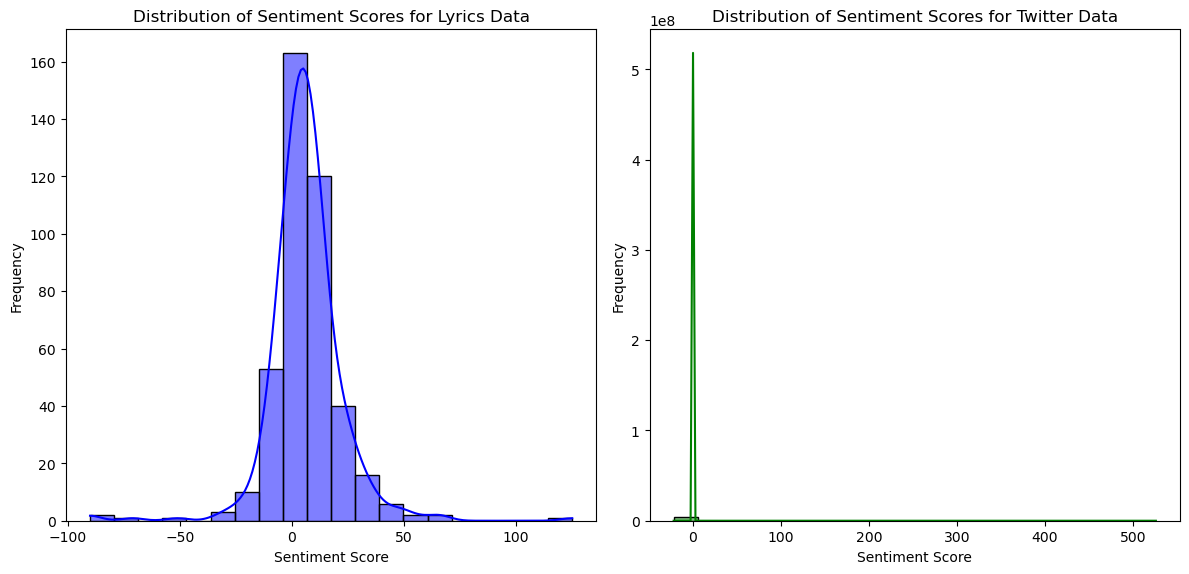

In [22]:
# Plot sentiment score distributions for lyrics_data and twitter_data
plt.figure(figsize=(12, 6))

# Sentiment scores for lyrics_data
plt.subplot(1, 2, 1)
sns.histplot(lyrics_data['sentiment_score'], bins=20, kde=True, color='blue')
plt.title('Distribution of Sentiment Scores for Lyrics Data')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# Sentiment scores for twitter_data
plt.subplot(1, 2, 2)
sns.histplot(twitter_data['sentiment_score'], bins=20, kde=True, color='green')
plt.title('Distribution of Sentiment Scores for Twitter Data')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Check for Outliers in Twitter Data to Explain Anomalous Sentiment Distribution

In [23]:
# Check for outliers in twitter_data
print(twitter_data['sentiment_score'].describe())

count    4.269837e+06
mean     3.731468e-01
std      1.187408e+00
min     -2.200000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.260000e+02
Name: sentiment_score, dtype: float64


### Remove Outlier with Extremely High Sentiment Score Skewing Data Distribution (simple method: checking min/max values, standard deviation, and quartiles). The Twitter data contains over 4.2 million sentiment scores, with a slightly positive average and a standard deviation of 1.19. Most scores are neutral or close to 0, but the maximum score of 526, significantly higher than the standard deviation, indicates a potential outlier that may be skewing the distribution.

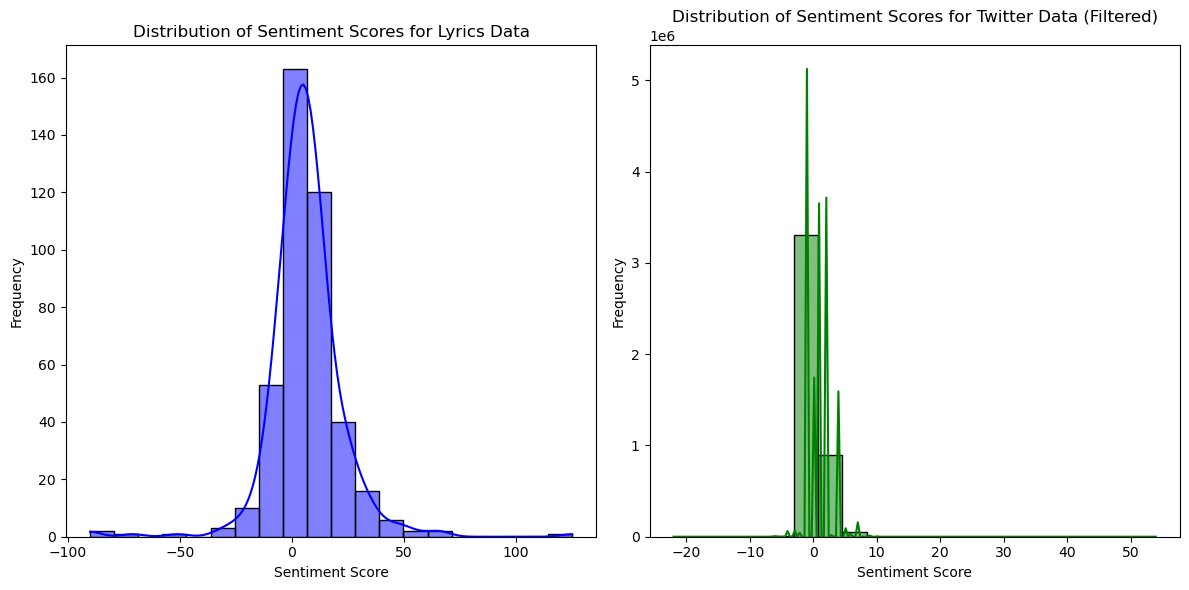

In [24]:
# Filter sentiment scores up to a threshold (outlier removal)
twitter_data_filtered = twitter_data[twitter_data['sentiment_score'] <= 100]

# Plot the distribution of sentiment scores for lyrics_data and filtered twitter_data
plt.figure(figsize=(12, 6))

# Distribution for lyrics_data sentiment scores
plt.subplot(1, 2, 1)
sns.histplot(lyrics_data['sentiment_score'], bins=20, kde=True, color='blue')
plt.title('Distribution of Sentiment Scores for Lyrics Data')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# Distribution for twitter_data sentiment scores (outlier removed)
plt.subplot(1, 2, 2)
sns.histplot(twitter_data_filtered['sentiment_score'], bins=20, kde=True, color='green')
plt.title('Distribution of Sentiment Scores for Twitter Data (Filtered)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [25]:
# Define positive and negative emoji sets
positive_emojis = ['😀', '😁', '😂', '😍', '🥰', '😊', '❤️', '😎', '🎉', '✨']
negative_emojis = ['😢', '😡', '😠', '😭', '💔', '😩', '😞', '😔', '😖', '😤']

# Function to calculate emoji sentiment from Twitter descriptions
def calculate_emoji_sentiment(description):
    if pd.isna(description):
        return 0
    sentiment_score = 0
    for char in description:
        if char in positive_emojis:
            sentiment_score += 1
        elif char in negative_emojis:
            sentiment_score -= 1
    return sentiment_score

# Apply the emoji sentiment calculation to the Twitter data
twitter_data['emoji_sentiment_score'] = twitter_data['description'].apply(calculate_emoji_sentiment)

# Calculate average sentiment for Cher and Robyn
cher_avg_sentiment = twitter_data[twitter_data['artist'] == 'cher']['emoji_sentiment_score'].mean().round(4)
robyn_avg_sentiment = twitter_data[twitter_data['artist'] == 'robyn']['emoji_sentiment_score'].mean().round(4)

# Display the average sentiment for both artists
print(f"The average emoji sentiment for Cher's followers is: {cher_avg_sentiment}, "
      f"and the average emoji sentiment for Robyn's followers is: {robyn_avg_sentiment}.")

The average emoji sentiment for Cher's followers is: 0.0143, and the average emoji sentiment for Robyn's followers is: 0.0092.


In [26]:
# Initialize counters for Cher and Robyn
cher_emoji_counter = Counter()
robyn_emoji_counter = Counter()

# Function to count emojis in Twitter descriptions for each artist
def count_emojis(description, artist):
    if pd.isna(description):
        return
    for char in description:
        if char in positive_emojis + negative_emojis:
            # Count emojis for the correct artist
            if artist == 'cher':
                cher_emoji_counter[char] += 1
            elif artist == 'robyn':
                robyn_emoji_counter[char] += 1

# Apply the emoji counting function to each description
twitter_data.apply(lambda row: count_emojis(row['description'], row['artist']), axis=1)

# Function to find the most popular emoji from a counter
def find_most_popular_emoji(emoji_counter, emoji_list):
    filtered_emoji_counts = {emoji: count for emoji, count in emoji_counter.items() if emoji in emoji_list}
    return max(filtered_emoji_counts, key=filtered_emoji_counts.get) if filtered_emoji_counts else None

# Find the most popular positive and negative emojis for Cher
cher_most_popular_positive = find_most_popular_emoji(cher_emoji_counter, positive_emojis)
cher_most_popular_negative = find_most_popular_emoji(cher_emoji_counter, negative_emojis)

# Find the most popular positive and negative emojis for Robyn
robyn_most_popular_positive = find_most_popular_emoji(robyn_emoji_counter, positive_emojis)
robyn_most_popular_negative = find_most_popular_emoji(robyn_emoji_counter, negative_emojis)

# Display the results
print(f"The most popular positive emoji for Cher is: {cher_most_popular_positive}")
print(f"The most popular negative emoji for Cher is: {cher_most_popular_negative}")

print(f"The most popular positive emoji for Robyn is: {robyn_most_popular_positive}")
print(f"The most popular negative emoji for Robyn is: {robyn_most_popular_negative}")


The most popular positive emoji for Cher is: ✨
The most popular negative emoji for Cher is: 💔
The most popular positive emoji for Robyn is: ✨
The most popular negative emoji for Robyn is: 💔


Q: What is the average sentiment of your two artists? 

***A: The average emoji sentiment for Cher's followers is: `0.0143,` and  the average emoji sentiment for Robyn's followers is: `0.0092.`***

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

***A:***

- ***The most popular positive emoji for Cher is: 'Sparkles'***
- ***The most popular negative emoji for Cher is: 'Broken Heart'***
- ***The most popular positive emoji for Robyn is: 'Sparkles'***
- ***The most popular negative emoji for Robyn is: 'Broken Heart'***

<center><b>References:</b></center>

- Hu, M., & Liu, B. (2004). Mining and summarizing customer reviews. Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD-2004), August 22-25, 2004, Seattle, WA, United States.
- Python Software Foundation. (n.d.). *os.path — Common pathname manipulations.* Python documentation. https://docs.python.org/3/library/os.path.html
- Python Software Foundation. (n.d.). *Built-in functions - Open.* Python documentation. https://docs.python.org/3/library/functions.html#open
- OpenAI. (2024). *ChatGPT (October 12 Version)* [Large language model]. https://chat.openai.com
- Gallagher, J. (2023, December 1). *Python startswith and endswith: Step-by-step guide.* Career Karma. https://careerkarma.com/blog/python-startswith-and-endswith/
- Faccioni, J. L. (2023, March 6). *How to write the Python if statement in one line.* LearnPython.com. https://learnpython.com/blog/python-if-in-one-line/
- pandas. (2024). *pandas.DataFrame.apply.* pandas documentation. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
- Jablonski, J. (2023, October 18). *Python's F-String: An improved string interpolation and formatting tool.* Real Python. https://realpython.com/python-f-strings/
- Omkar, P. (2023). *Emosent-py* (Version 0.1.7) [Python package]. PyPI. https://pypi.org/project/emosent-py/
- Emojipedia. (2024). *Emoji statistics.* Emojipedia. https://emojipedia.org/stats
- Emojitracker. (n.d.). *Emoji statistics on Twitter in real-time.* Emojitracker. https://emojitracker.com/